# Create images with the Azure DALLE-2 API
<img src="../media/dalle2.png" alt="drawing" style="width:1200px;"/>

Prerequisites:
- An Azure Computer Vision resource. Consult the [documentation](https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/image-analysis-client-library?pivots=programming-language-python&tabs=linux%2Cvisual-studio) to learn more.
- Access to the [Azure OpenAI preview](https://aka.ms/oaiapply) - express interest for DALL-E, however consider the __limited availability at the moment__   

In this notebook:

1. Creating images from scratch based on a text prompt
2. Utilize the Florence model to derive descriptive captions from a pre-existing image, then construct a prompt using these descriptions to facilitate the generation of a similar image via DALL-E 2.

Check out the [OpenAI API documentation](https://beta.openai.com/docs/guides/images) for more information. 

In [1]:
import sys
sys.path.insert(0, '..')

import os
import time
import openai
from PIL import Image
import requests
import math
from io import BytesIO
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import azure.ai.vision as sdk

from utils import show_images

In [2]:
load_dotenv('../.env')

# Azure OpenAI DALLE
api_key = os.getenv('AOAI_API_KEY') # key of your Azure OpenAI resource
api_base = os.getenv('AOAI_ENDPOINT') # endpoint of your Azure OpenAI resource
api_version = '2022-08-03-preview'

# Azure Computer Vision
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

# Create Images from a Text Prompt
The image generations endpoint allows you to create an original image given a text prompt. The more detailed the description, the more likely you are to get the result that you or your end user want.

<img src="../media/prompt-design.png" alt="prompt design" style="width:1200px;"/>

Source: [DALL-E 2 Prompt Book](https://dallery.gallery/the-dalle-2-prompt-book/)  

In [3]:
def create_aoai_dalle_images(prompt, resolution = "1024x1024", n=4):
    """
    Call Azure OpenAI API to create n DALLE images based on prompt. 
    
    Parameters
    ----------
    prompt : str
        Image caption prompt.
    resolution : str
        Target resolution of image.
    n : int
        Number of images to create.
    """
    urls = []
    for image_idx in range(n):

        url = "{}dalle/text-to-image?api-version={}".format(api_base, api_version)

        headers= { "api-key": api_key, "Content-Type": "application/json" }
        body = {
        "caption": prompt,
        "resolution": resolution,
        }

        submission = requests.post(url, headers=headers, json=body)
        operation_location = submission.headers['Operation-Location']
        retry_after = submission.headers['Retry-after']
        status = ""

        try:
            while (status != "Succeeded"):
                time.sleep(int(retry_after))
                response = requests.get(operation_location, headers=headers)
                status = response.json()['status']
            
            image_url = response.json()['result']['contentUrl']
            urls.append(image_url)
        except Exception as e:
            print(f"Exception while generating image {image_idx} of {n}. Skipping image.")
            print(e)
    return urls

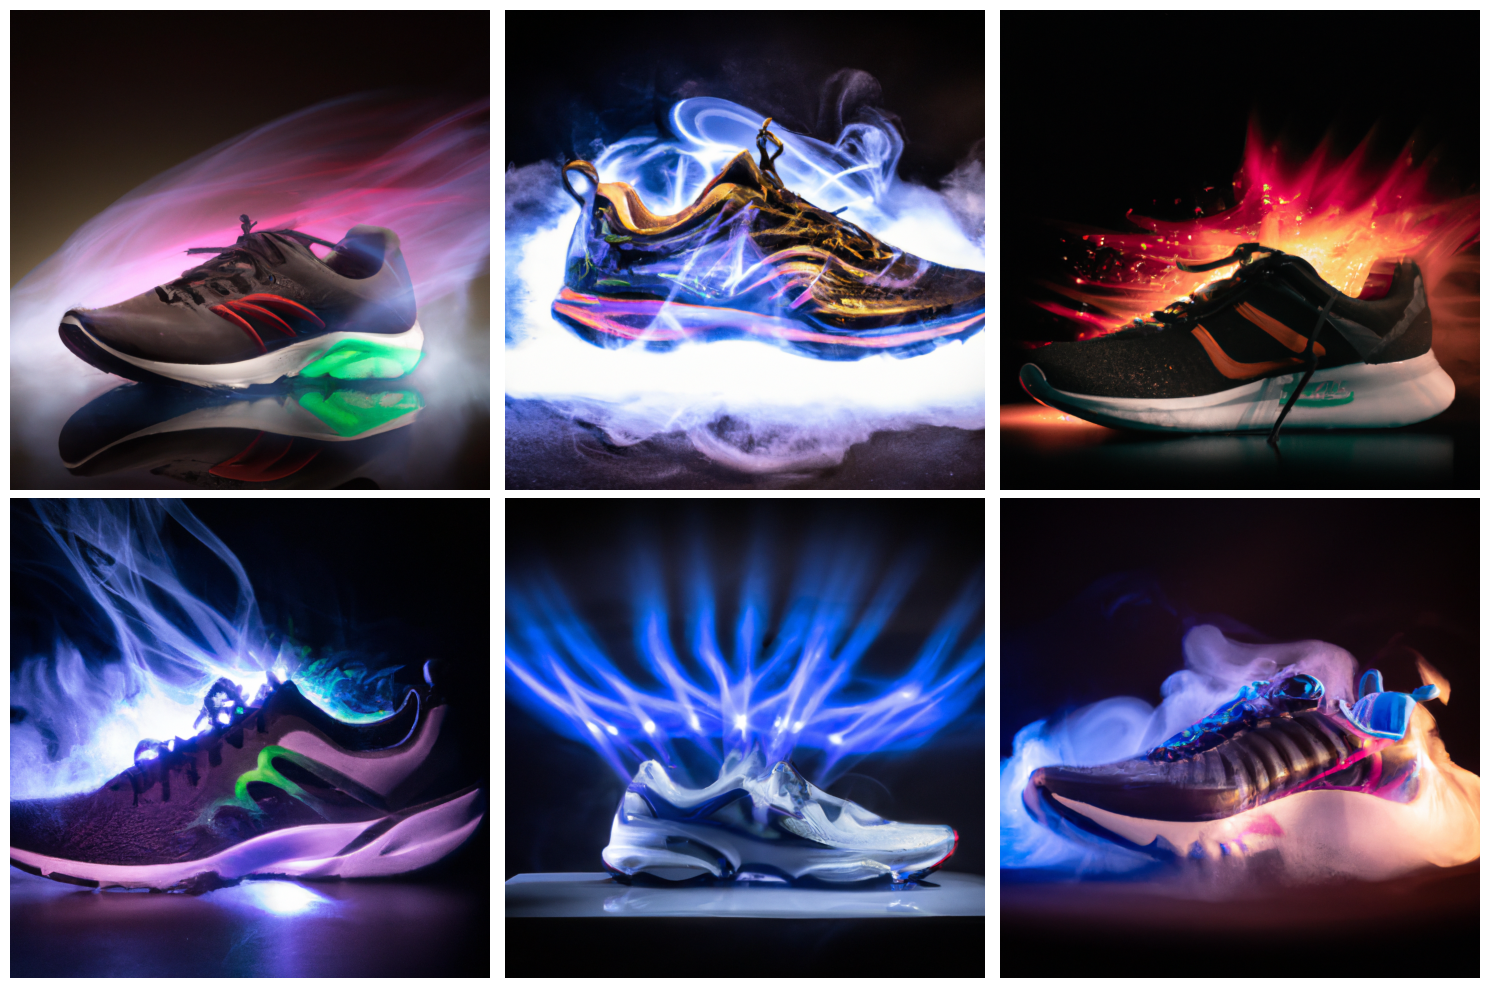

In [4]:
urls = create_aoai_dalle_images(prompt='A magical running shoe, futuristic, stunning product studio photography, low-key lighting, bokeh, smoke effects',
                                resolution = "1024x1024",
                                n = 6)

savedir = './results/running-shoe'

# png_filenames = [os.path.join(savedir, image) for image in os.listdir(savedir) if image.endswith('.png')]
show_images(images=urls, cols=3, savedir=savedir) 

# Prompt based Image Recreation DALL-E 2 using Florence Captions
Now we will use two distinct AI models, Florence and DALL-E 2, in a complementary fashion. The first step involves using the Florence model to extract descriptive captions from an existing image. The next step takes advantage of these descriptions to build a prompt for DALL-E 2. Our goal is to instruct DALL-E 2 to generate an image closely resembling the original one. This process illustrates a practical use case where different AI models can be employed together to achieve a specific outcome.

This example is based on the [image to image demo](https://github.com/retkowsky/image_to_image_Azure) by Serge Retkowsky.

In [5]:
def analyze_image(imagefile):

    service_options = sdk.VisionServiceOptions(endpoint, key)

    vision_source = sdk.VisionSource(filename=imagefile)

    analysis_options = sdk.ImageAnalysisOptions()

    analysis_options.features = (
        sdk.ImageAnalysisFeature.CAPTION |
        sdk.ImageAnalysisFeature.TAGS
    )

    image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)

    result = image_analyzer.analyze()

    caption = result.caption.content
    tags_str = ", ".join(tag.name for tag in result.tags)

    return caption, tags_str

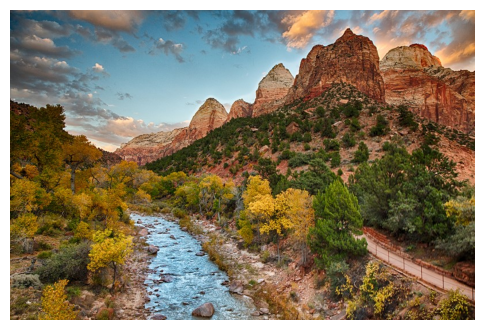

In [6]:
source_img = './source/national-park.jpg' # existing image

plt.figure(figsize=(6,6))

img = Image.open(source_img)
plt.imshow(img)
plt.axis('off')

plt.show()

In [7]:
caption, tags = analyze_image(source_img)

print(f'Caption: {caption}')
print(f'Tags:    {tags}')


Caption: a river running through a canyon with Zion National Park in the background
Tags:    landscape, outdoor, cloud, plant, sky, tree, wilderness, ravine, water, national park, mountain, nature, natural landscape, canyon, river, autumn, grass, ground, fall


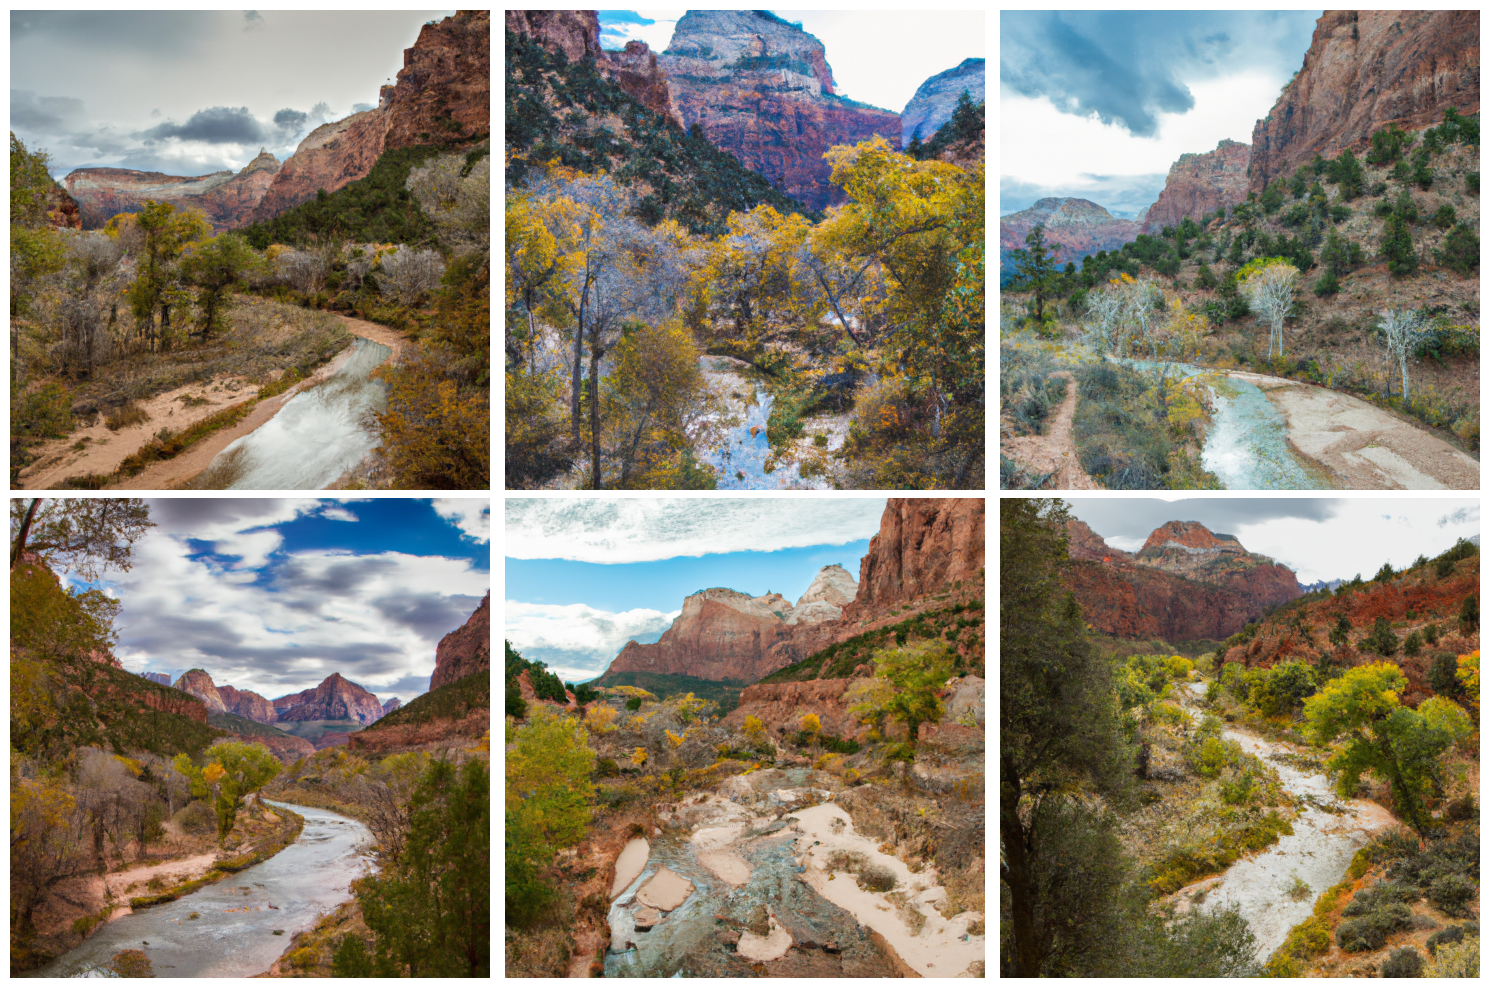

In [8]:
urls = create_aoai_dalle_images(prompt=caption + ', ' + tags,
                                resolution = "1024x1024",
                                n = 6)

show_images(images=urls, cols=3)